In [16]:
import pickle
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import nltk

# --- 1. Download necessary NLTK data (run once) ---
nltk.download('stopwords')
nltk.download('wordnet')

# --- 2. Load the `newsgroups` file ---
print("Attempting to load 'newsgroups' file...")
try:
    with open('newsgroups', 'rb') as f:
        newsgroup_data = pickle.load(f)

    # *** ADJUSTMENT HERE: If newsgroup_data is directly a list ***
    if isinstance(newsgroup_data, list):
        documents = newsgroup_data
        print(f"Newsgroups data loaded successfully. Detected {len(documents)} documents.")
    else:
        print("Error: Expected 'newsgroups' data to be a list, but got a different type.")
        documents = [] # Initialize as empty to prevent further errors

except FileNotFoundError:
    print("Error: 'newsgroups' file not found. Make sure it's in the correct directory.")
    documents = [] # Initialize as empty to prevent further errors
except Exception as e:
    print(f"An error occurred while loading the newsgroups file: {e}")
    documents = []

Attempting to load 'newsgroups' file...
Newsgroups data loaded successfully. Detected 2000 documents.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
# --- 3. Clean the corpus and apply LDA & NMF ---
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Cleans and preprocesses text:
    - Removes non-alphabetic characters
    - Converts to lowercase
    - Tokenizes
    - Removes stopwords
    - Lemmatizes
    """
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic characters
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)



In [18]:
if documents: # Proceed only if documents were loaded
    print("\nStarting text preprocessing...")
    processed_documents = [preprocess_text(doc) for doc in documents]
    print(f"Text preprocessing complete. Processed {len(processed_documents)} documents.")

    # --- TF-IDF Vectorizer for NMF ---
    # NMF works well with TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(processed_documents)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    print(f"TF-IDF Vectorization complete. Vocabulary size: {len(tfidf_feature_names)}")

    # --- Count Vectorizer for LDA ---
    # LDA works well with raw counts (Bag-of-Words)
    count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    count_data = count_vectorizer.fit_transform(processed_documents)
    count_feature_names = count_vectorizer.get_feature_names_out()
    print(f"Count Vectorization complete. Vocabulary size: {len(count_feature_names)}")

    num_topics = 10

    # --- Apply NMF ---
    print(f"\nApplying NMF with {num_topics} topics...")
    nmf_model = NMF(n_components=num_topics, random_state=42, init='nndsvda') # 'nndsvda' can sometimes improve NMF convergence
    nmf_topic_features = nmf_model.fit_transform(tfidf)
    print("NMF complete.")

    # --- Apply LDA ---
    print(f"\nApplying LDA with {num_topics} topics...")
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42,
                                          learning_method='batch', # 'batch' is generally more stable than 'online'
                                          max_iter=20) # Increase iterations for better convergence
    lda_topic_features = lda_model.fit_transform(count_data)
    print("LDA complete.")
else:
    print("Cannot proceed with topic modeling as no documents were loaded.")




Starting text preprocessing...
Text preprocessing complete. Processed 2000 documents.
TF-IDF Vectorization complete. Vocabulary size: 8640
Count Vectorization complete. Vocabulary size: 8640

Applying NMF with 10 topics...
NMF complete.

Applying LDA with 10 topics...
LDA complete.


In [19]:
# --- 4. Plot the 10 most important words and a wordcloud ---

def display_topics(model, feature_names, no_top_words):
    """
    Prints the top words for each topic.
    """
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")

def plot_top_words(model, feature_names, no_top_words, title):
    """
    Plots the top words for each topic as bar charts.
    """
    # Calculate rows for subplots
    num_rows = (num_topics + 1) // 2 # Ensures enough rows for topics
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 4 * num_rows), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features[::-1], weights[::-1], color='skyblue')
        ax.set_title(f'Topic {topic_idx + 1}', loc='right', fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.tick_params(axis='y', labelsize=9)
        ax.invert_yaxis() # To display the most important word at the top

    # Hide any unused subplots if num_topics is odd
    for i in range(topic_idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

def generate_wordcloud_for_topics(model, feature_names, num_topics, no_top_words, title_prefix):
    """
    Generates a word cloud for each topic.
    """
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        # Create a dictionary of words and their weights for the word cloud
        word_weights = {feature_names[i]: topic[i] for i in top_features_ind}

        # Ensure that word_weights is not empty before generating wordcloud
        if not word_weights:
            print(f"Skipping word cloud for {title_prefix} Topic {topic_idx + 1}: No words found.")
            continue

        wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Blues').generate_from_frequencies(word_weights)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{title_prefix} Topic {topic_idx + 1} Word Cloud", fontsize=14)
        plt.show()

no_top_words = 10 # For bar plots
num_words_for_wordcloud = 50 # For word clouds, typically more words are useful



In [20]:

print("\n--- NMF Topic Analysis ---")
display_topics(nmf_model, tfidf_feature_names, no_top_words)




--- NMF Topic Analysis ---
Topic 1:
dont think people thing time good problem say like way
Topic 2:
card controller port bus irq serial mhz pc vga scsi
Topic 3:
game team year player win play season hockey league leaf
Topic 4:
chastity intellect skepticism njxp gebcadredslpittedu shameful surrender gordon bank soon
Topic 5:
drive scsi disk floppy hard cable boot problem power mac
Topic 6:
car driver price mile dealer driving auto owner speed engine
Topic 7:
thanks bike know im email advance info like looking lot
Topic 8:
space nasa data program launch information use shuttle available orbit
Topic 9:
god freewill satan say tell atheism belief angel atheist argument
Topic 10:
monitor simms apple vram mb chip color mac pin memory




In [21]:
plot_top_words(nmf_model, tfidf_feature_names, no_top_words, 'Top 10 Words per NMF Topic')


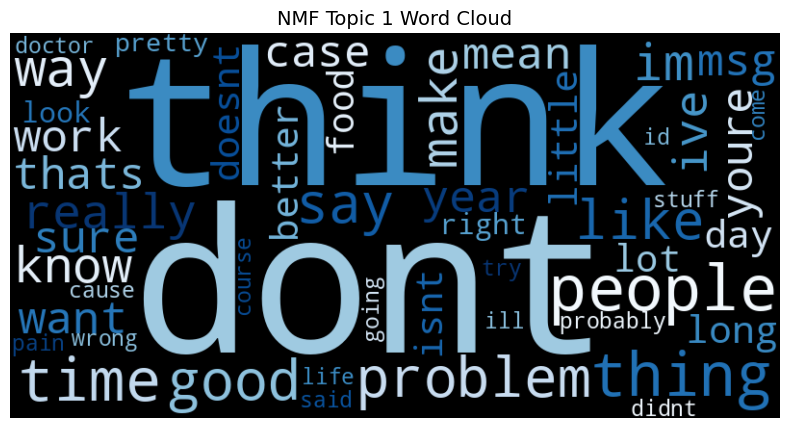

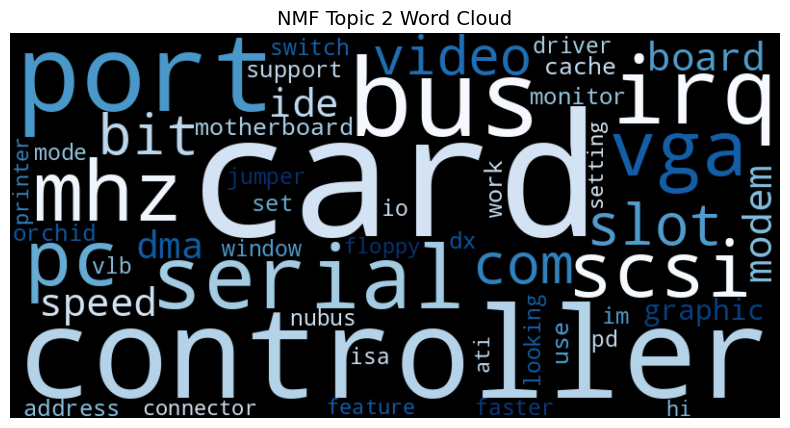

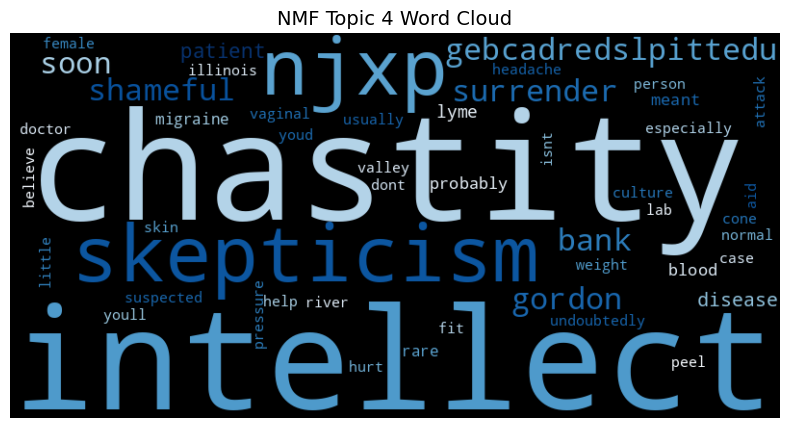

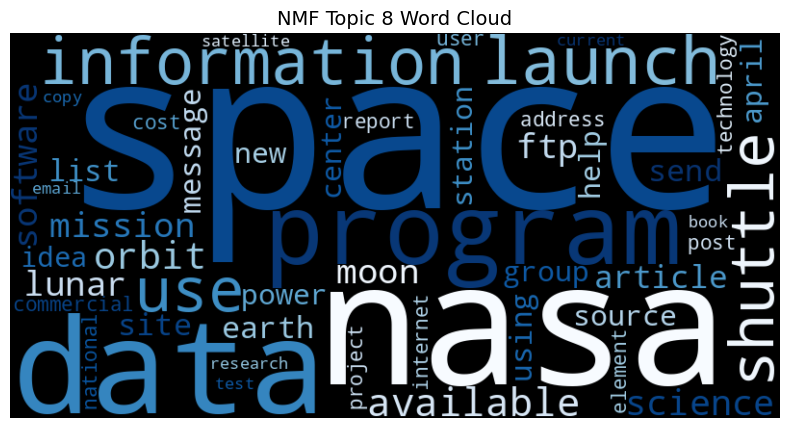

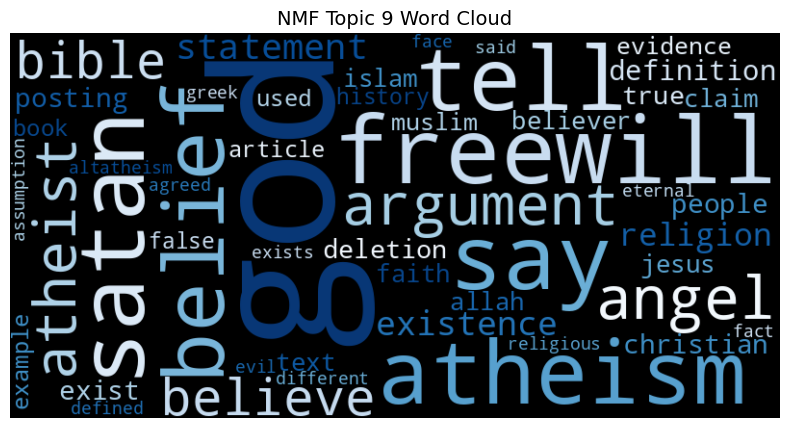

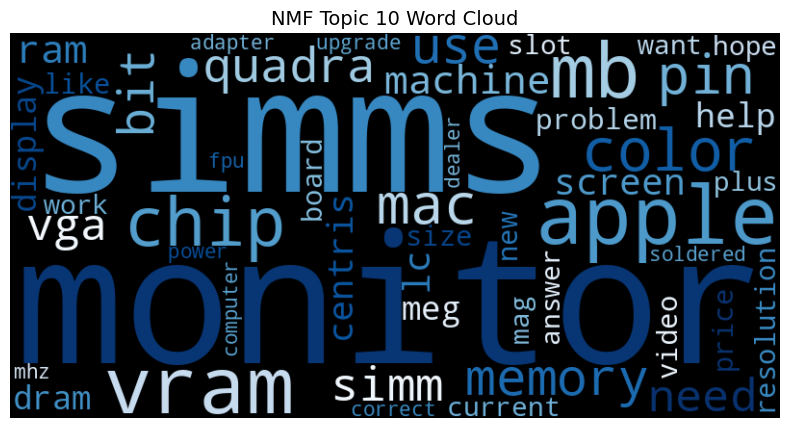

In [22]:
generate_wordcloud_for_topics(nmf_model, tfidf_feature_names, num_topics, num_words_for_wordcloud, 'NMF')

In [23]:

print("\n--- LDA Topic Analysis ---")
display_topics(lda_model, count_feature_names, no_top_words)



--- LDA Topic Analysis ---
Topic 1:
drive disk scsi hard controller run game bios floppy rom
Topic 2:
card thanks work use problem like know monitor chip help
Topic 3:
space center ground data nasa cancer available launch research information
Topic 4:
patient problem bos doctor chi pit det la tor van
Topic 5:
people god think dont bike time say know like thing
Topic 6:
car like good dont im use new time know price
Topic 7:
msg food people dont thing problem pain cause say time
Topic 8:
data space program pm use science rate lunar year sequence
Topic 9:
post game know king period shot bank flame gm soon
Topic 10:
team year game dont player think like good play season




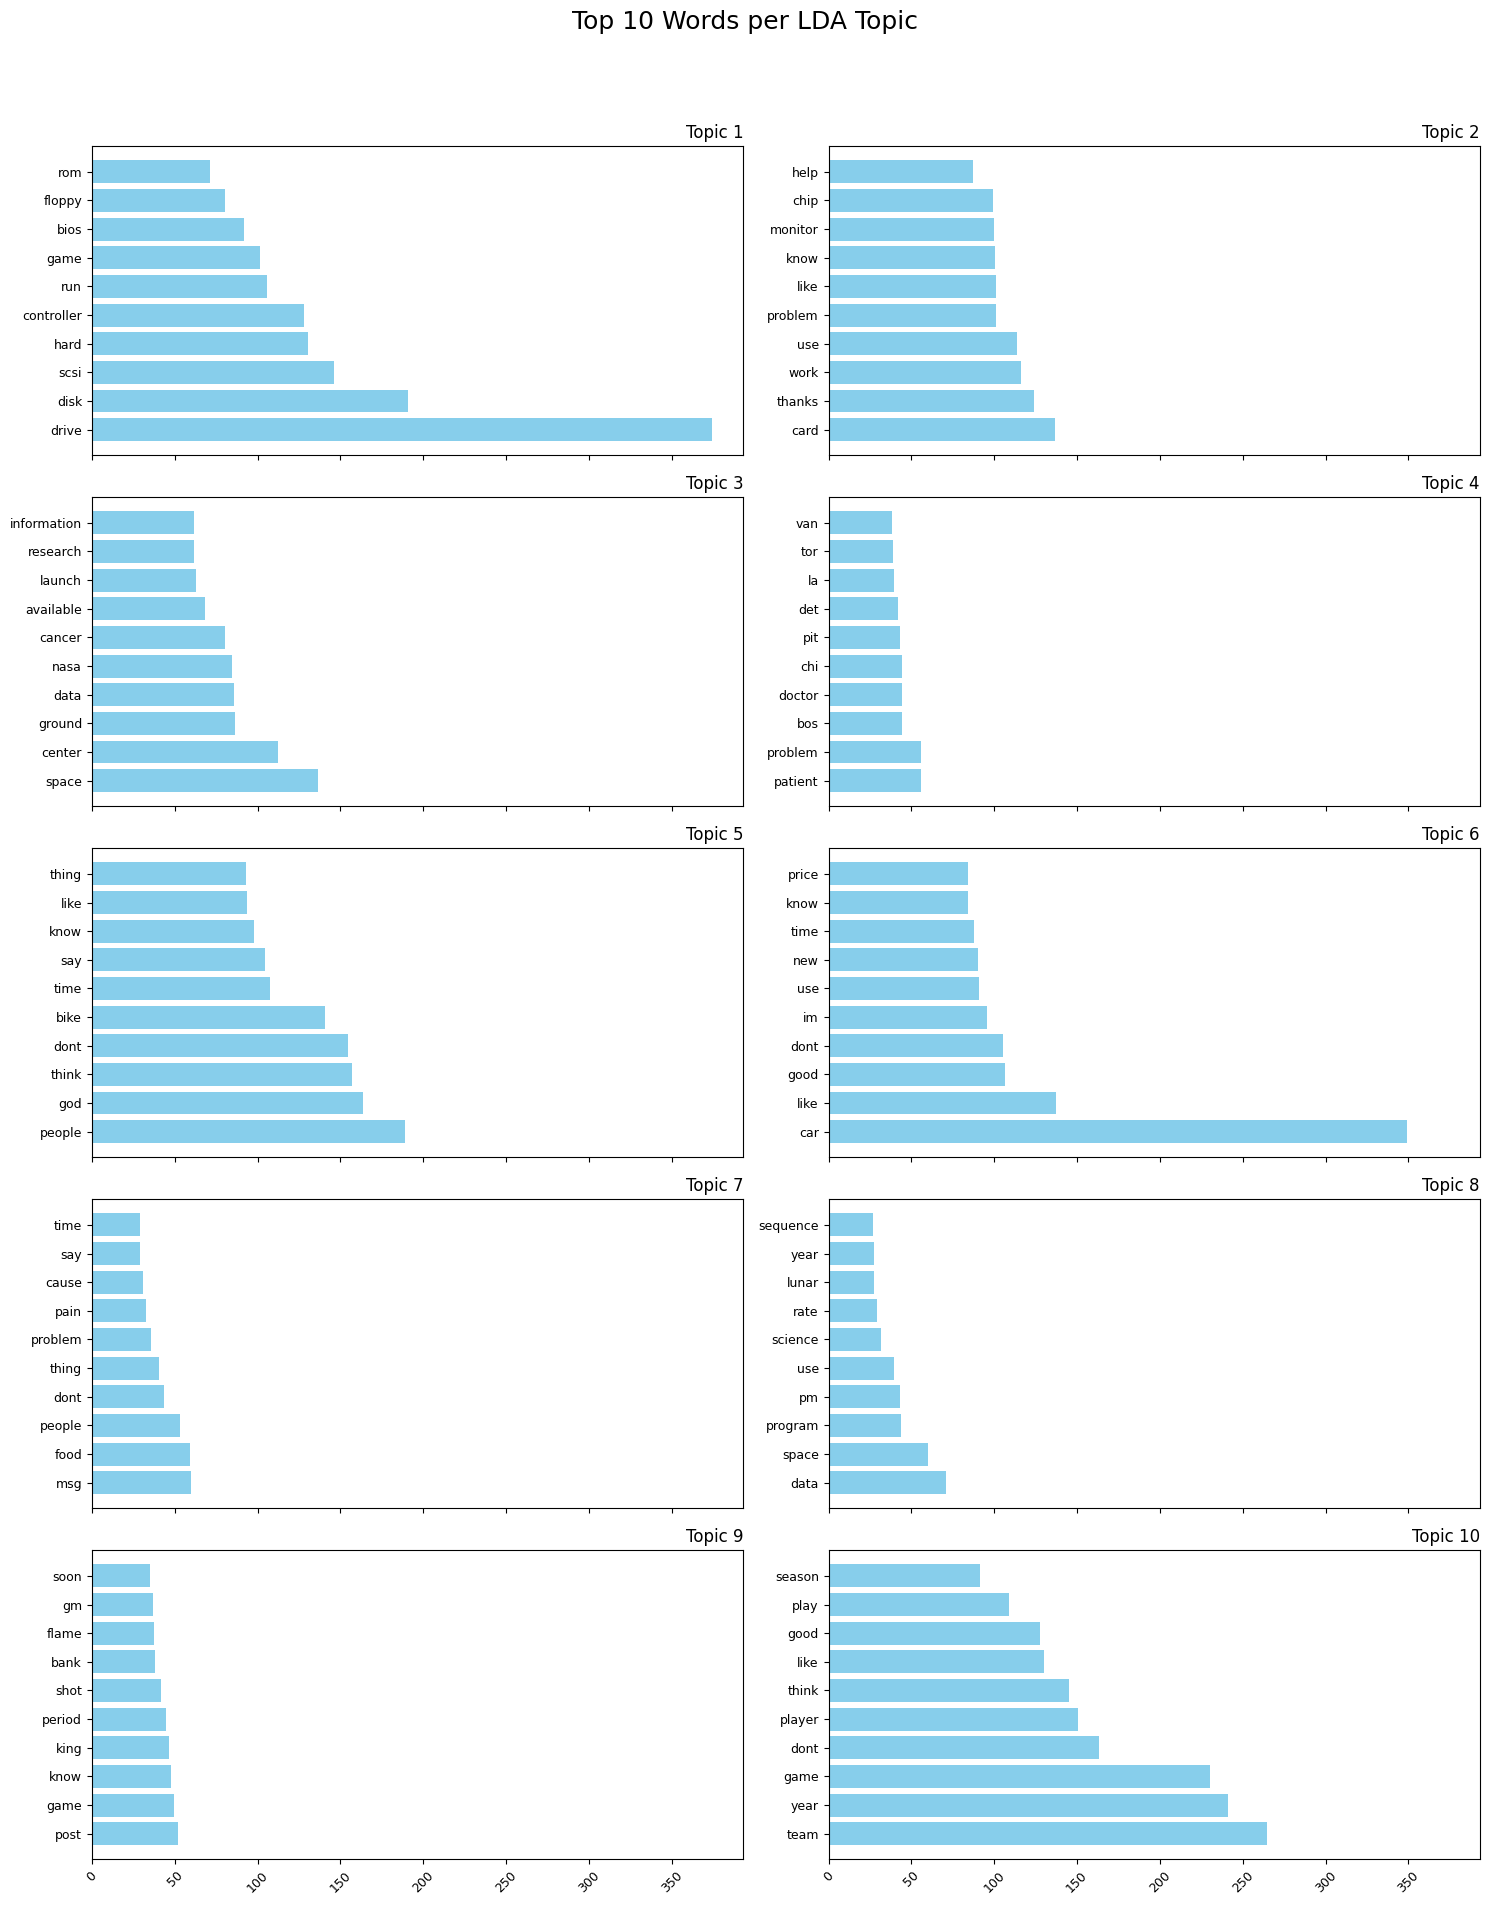

In [24]:
plot_top_words(lda_model, count_feature_names, no_top_words, 'Top 10 Words per LDA Topic')


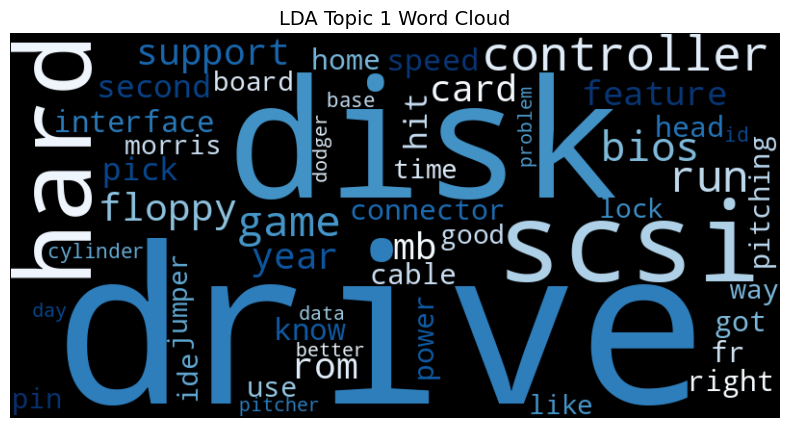

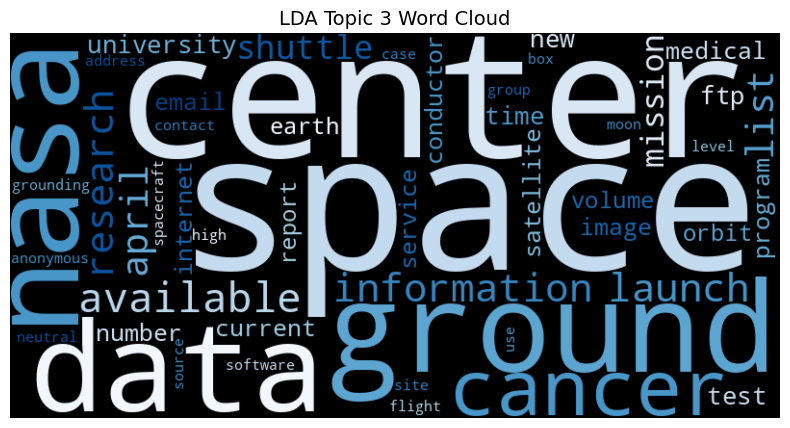

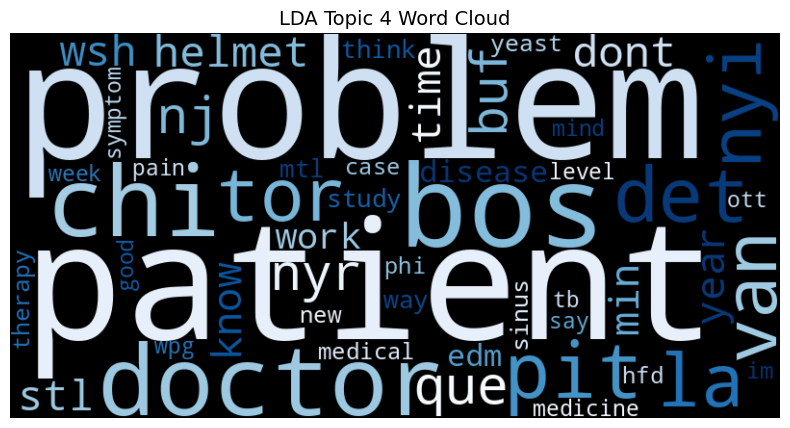

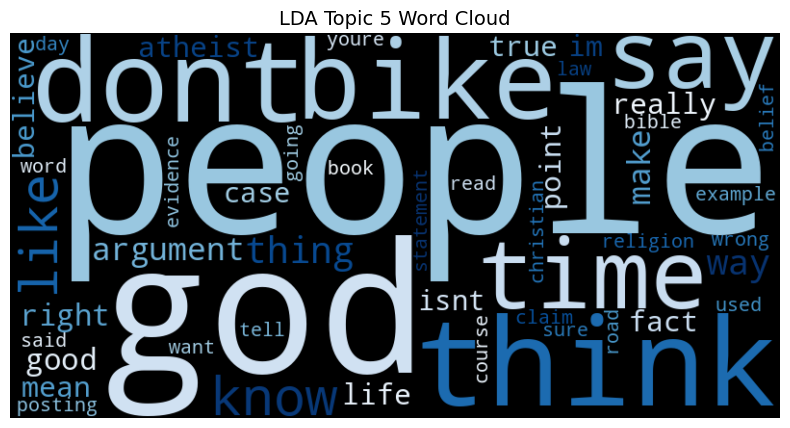

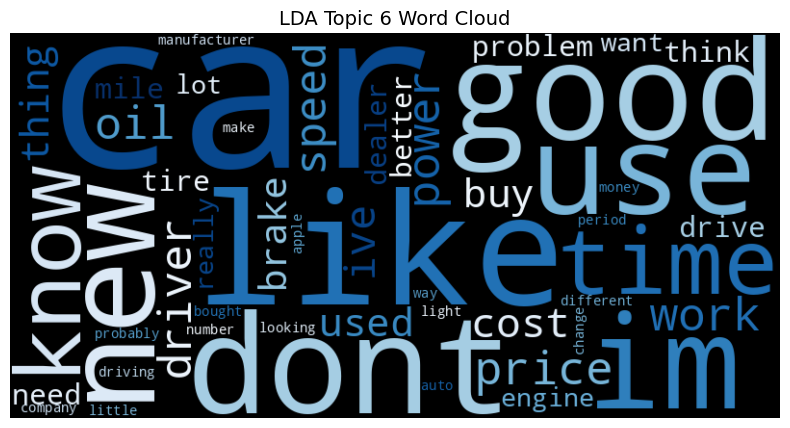

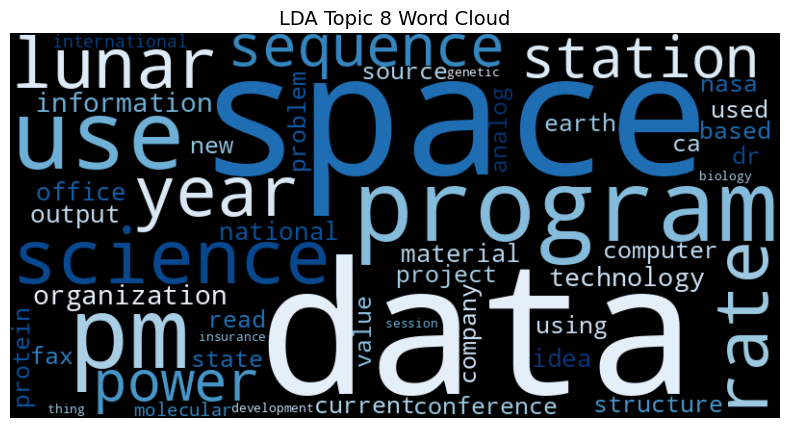

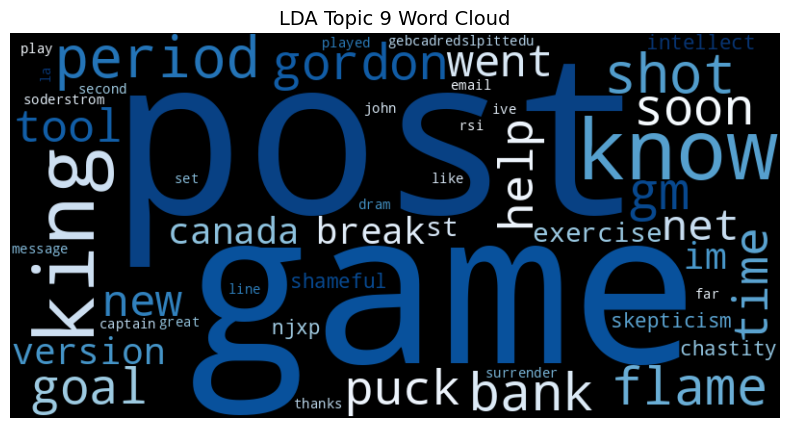

In [25]:
generate_wordcloud_for_topics(lda_model, count_feature_names, num_topics, num_words_for_wordcloud, 'LDA')

## Sentiment Analysis

In [28]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import re

# Download VADER lexicon (if not already downloaded)
nltk.download('vader_lexicon')

# Function to apply VADER sentiment analysis
def analyze_sentiment_vader(text):
    """
    Applies the VADER algorithm to a given text and returns the sentiment label and compound score.
    """
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)
    compound_score = vs['compound']

    if compound_score >= 0.05:
        sentiment_label = "Positive"
    elif compound_score <= -0.05:
        sentiment_label = "Negative"
    else:
        sentiment_label = "Neutral"

    return sentiment_label, compound_score

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [33]:
# Load the dataset (replace 'tweets-data.csv' with your actual file path if different)
# Make sure 'tweets-data.csv' is in the same directory as your notebook or provide the full path.
try:
    df = pd.read_csv('tweets-data.csv')
except FileNotFoundError:
    print("Error: 'tweets-data.csv' not found. Please ensure the file is in the correct directory.")
    # Create a dummy DataFrame for demonstration if the file is not found
    data = {'text': [
        "This is a great movie!",
        "I hate this product, it's terrible.",
        "The weather is just okay today.",
        "Feeling very happy and excited about this new opportunity.",
        "Absolutely disgusted by the service here.",
        "It's raining outside.",
        "Wonderful news!",
        "Such a frustrating experience.",
        "Neutral statement about an event.",
        "Best day ever!"
    ]}
    df = pd.DataFrame(data)
    print("Using a dummy DataFrame for demonstration.")

# Take a sample of 500 rows if the DataFrame has more than 500 rows
if len(df) > 500:
    df_sample = df.sample(n=500, random_state=42).copy() # Use .copy() to avoid SettingWithCopyWarning
else:
    df_sample = df.copy() # Use .copy() even if not sampling to ensure independent copy

# Clean the tweet text
def clean_tweet_text(text):
    """
    Cleans the tweet text by removing URLs, mentions, hashtags, and special characters.
    It also ensures that tokens are joined with a single space.
    """
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'#\w+', '', text) # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters, keep letters and spaces
    text = ' '.join(text.split()) # Replace multiple spaces with a single space
    return text.strip() # Remove leading/trailing whitespace

df_sample['cleaned_text'] = df_sample['Tweets'].apply(clean_tweet_text)

# Apply the sentiment analysis function to the cleaned text
df_sample[['sentiment_label', 'sentiment_score']] = df_sample['cleaned_text'].apply(
    lambda x: pd.Series(analyze_sentiment_vader(x))
)

# Display the first few rows with the new columns
print("\nDataFrame with Sentiment Analysis Results:")
print(df_sample[['Tweets', 'cleaned_text', 'sentiment_label', 'sentiment_score']].head())

# Optional: Display value counts for sentiment labels
print("\nSentiment Label Distribution:")
print(df_sample['sentiment_label'].value_counts())


DataFrame with Sentiment Analysis Results:
                                                 Tweets  \
2899  Le #DessinDePresse de Sanaga : ls sont morts c...   
594   #Russia #Wagner #RussiaCivilWar https://t.co/P...   
2870  Exclusive content -https://t.co/oEiSIIB2Z1\n.\...   
52    Auch heute geht die politische Nachricht des T...   
1391  @crazyclipsonly Same type that would take a ho...   

                                           cleaned_text sentiment_label  \
2899  Le de Sanaga ls sont morts comme ils ont vcu R...         Neutral   
594                                                             Neutral   
2870                                  Exclusive content        Positive   
52    Auch heute geht die politische Nachricht des T...        Negative   
1391  Same type that would take a homemade PlayStati...         Neutral   

      sentiment_score  
2899           0.0000  
594            0.0000  
2870           0.1280  
52            -0.5994  
1391           0.0000  

Senti

In [37]:
import pandas as pd
from transformers import pipeline
import re
import os

# Install transformers if you haven't already
# !pip install transformers

# Load the dataset (replace 'tweets-data.csv' with your actual file path if different)
try:
    df = pd.read_csv('tweets-data.csv')
except FileNotFoundError:
    print("Error: 'tweets-data.csv' not found. Please ensure the file is in the correct directory.")
    # Create a dummy DataFrame for demonstration if the file is not found
    data = {'text': [
        "This is a great movie!",
        "I hate this product, it's terrible.",
        "The weather is just okay today.",
        "Feeling very happy and excited about this new opportunity.",
        "Absolutely disgusted by the service here.",
        "It's raining outside.",
        "Wonderful news!",
        "Such a frustrating experience.",
        "Neutral statement about an event.",
        "Best day ever!"
    ]}
    df = pd.DataFrame(data)
    print("Using a dummy DataFrame for demonstration.")

# Take a sample of 500 rows if the DataFrame has more than 500 rows
if len(df) > 500:
    df_sample = df.sample(n=500, random_state=42).copy() # Use .copy() to avoid SettingWithCopyWarning
else:
    df_sample = df.copy() # Use .copy() even if not sampling to ensure independent copy

# --- Debugging Step 1: Check the size of df_sample ---
print(f"Size of df_sample before cleaning: {len(df_sample)} rows")


# Clean the tweet text
def clean_tweet_text(text):
    """
    Cleans the tweet text by removing URLs, mentions, hashtags, and special characters.
    It also ensures that tokens are joined with a single space.
    """
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'#\w+', '', text) # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters, keep letters and spaces
    text = ' '.join(text.split()) # Replace multiple spaces with a single space
    return text.strip() # Remove leading/trailing whitespace

df_sample['cleaned_text'] = df_sample['Tweets'].apply(clean_tweet_text)

# --- Debugging Step 2: Check for empty strings after cleaning ---
empty_cleaned_texts = df_sample['cleaned_text'].apply(lambda x: x == "").sum()
print(f"Number of empty cleaned texts: {empty_cleaned_texts}")


# Initialize the sentiment analysis pipeline
print("Initializing sentiment analysis pipeline (this may download a model if it's the first time)...")
try:
    sentiment_pipeline = pipeline("sentiment-analysis")
    print("Sentiment analysis pipeline initialized.")
except Exception as e:
    print(f"Error initializing pipeline: {e}")
    print("Please ensure you have an active internet connection for the first run to download the model.")
    exit()

print("Performing sentiment analysis on tweets one by one...")
sentiment_labels = []
sentiment_scores = []

# Iterate through each cleaned text
for index, cleaned_text in df_sample['cleaned_text'].items():
    try:
        # Pass each text as a list with one element to the pipeline
        # The pipeline expects an iterable of strings
        results = sentiment_pipeline([cleaned_text])
        # The result is a list of dictionaries, so we take the first element
        result = results[0]
        sentiment_labels.append(result['label'])
        sentiment_scores.append(result['score'])
    except Exception as e:
        print(f"Error processing text at index {index} ('{cleaned_text}'): {e}")
        # Append placeholder results to maintain length consistency
        sentiment_labels.append('ERROR')
        sentiment_scores.append(0.0)

print("Sentiment analysis complete.")

# --- Debugging Step 3: Critical Check for Mismatched Lengths ---
if len(sentiment_labels) != len(df_sample):
    print(f"Mismatch detected! Length of sentiment_labels ({len(sentiment_labels)}) does not match df_sample ({len(df_sample)})")
    # This should ideally not happen when processing one by one and appending placeholders.
    # If it does, there's a more fundamental issue with how results are being collected.
    # For robust handling, if this check still fails:
    diff = len(df_sample) - len(sentiment_labels)
    if diff > 0:
        print(f"Padding sentiment results with {diff} neutral entries.")
        sentiment_labels.extend(['Neutral'] * diff)
        sentiment_scores.extend([0.0] * diff)
    elif diff < 0:
        print(f"Truncating sentiment results by {-diff} entries.")
        sentiment_labels = sentiment_labels[:len(df_sample)]
        sentiment_scores = sentiment_scores[:len(df_sample)]


# Add new columns to the DataFrame
df_sample['sentiment_label_ml'] = sentiment_labels
df_sample['sentiment_score_ml'] = sentiment_scores

# Display the first few rows with the new columns
print("\nDataFrame with Machine Learning Sentiment Analysis Results:")
print(df_sample[['Tweets', 'cleaned_text', 'sentiment_label_ml', 'sentiment_score_ml']].head())

# Optional: Display value counts for sentiment labels
print("\nSentiment Label Distribution (ML Model):")
print(df_sample['sentiment_label_ml'].value_counts())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Size of df_sample before cleaning: 500 rows
Number of empty cleaned texts: 74
Initializing sentiment analysis pipeline (this may download a model if it's the first time)...


Device set to use cpu


Sentiment analysis pipeline initialized.
Performing sentiment analysis on tweets one by one...


Token indices sequence length is longer than the specified maximum sequence length for this model (934 > 512). Running this sequence through the model will result in indexing errors


Error processing text at index 188 ('La Rebelin del Grupo Wagner Un Desafo Crtico para el Gobierno Ruso La rebelin del Grupo Wagner ha sacudido el establishment poltico ruso Este grupo un contratista militar privado con estrechos vnculos con el Kremlin ha sido acusado de llevar a cabo numerosas atrocidades en Ucrania y Siria La rebelin donde un grupo de combatientes de Wagner se amotinaron contra el comando ruso oficial ha planteado serios interrogantes sobre la lealtad del grupo hacia el gobierno ruso La rebelin comenz el de junio de cuando un grupo de combatientes de Wagner se neg a obedecer rdenes de llevar a cabo una misin en Ucrania Los combatientes al parecer descontentos con su remuneracin y condiciones tomaron como rehenes a sus comandantes y exigieron ser llevados de regreso a Rusia Finalmente la rebelin fue sofocada por fuerzas especiales rusas aunque se hablo de una negociacin pero lo cierto es que ha dejado un interrogante en el panorama poltico ruso La rebelin ha planteado

In [3]:
import pandas as pd
from transformers import pipeline

# Load the dataset
df = pd.read_csv("spam.csv", encoding="latin-1")
df.columns = ["text", "label"]

# Load your LLM from Hugging Face via the transformers pipeline
classifier = pipeline(
    "text-generation",
    model="gpt2",
    max_new_tokens=10,
)

# Function to classify an email text using prompt engineering
def classify_email(email_text):
    prompt = (
        f"Classify this e-mail as 'spam' or 'ham' only. E-mail:\n{email_text}\n\nClass:"
    )
    result = classifier(prompt, do_sample=False)[0]["generated_text"]
    # Extract last word after 'Class:' as prediction
    prediction = result.split("Class:")[-1].strip().split()[0].lower()
    return "spam" if "spam" in prediction else "ham"

# Apply to the first 10 emails for demonstration (adjust as needed)
df["predicted"] = df["text"].head(10).apply(classify_email)

# Print comparison of true vs predicted
print(df.head(10)[["label", "predicted"]])


Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_i

  label predicted
0   ham       ham
1   ham      spam
2  spam       ham
3   ham       ham
4   ham       ham
5  spam       ham
6   ham       ham
7   ham       ham
8  spam       ham
9  spam       ham


In [11]:
!pip install -U transformers



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 62.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


In [5]:
from transformers import pipeline

gen = pipeline("text-generation", model="gpt2")
out = gen("Hello, my name is", max_new_tokens=5)
print(out)


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hello, my name is Mark L. C.'}]
